## Importing Packages & Datasets

### Importing Packages

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import VarianceThreshold,RFE, mutual_info_classif, RFECV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, make_scorer, precision_recall_curve
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier


### Importing Dataset

In [3]:
# CHANGE PATH
fold_1 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/fold_1.csv')
fold_2 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/fold_2.csv')
fold_3 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/fold_3.csv')
fold_4 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/fold_4.csv')
fold_5 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/fold_5.csv')
smote_fold_1 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/smote_fold_1.csv')
smote_fold_2 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/smote_fold_2.csv')
smote_fold_3 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/smote_fold_3.csv')
smote_fold_4 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/smote_fold_4.csv')
smote_fold_5 = pd.read_csv('/Users/Sreenithi/Desktop/finalised_datasets/smote_train_data/smote_fold_5.csv')

## Logistic Regression Model

We will proceed with this flow:

1. Logistic Regression Model Development
Train a logistic regression model on the preprocessed dataset, adjusting hyperparameters and exploring regularization techniques (e.g., L1 or L2) to prevent overfitting.

2. Model Evaluation
Evaluate the model's performance using utility fraud-specific metrics such as precision, recall, F1-score, AUC-ROC, and confusion matrix analysis.
Assess the balance between false positives and false negatives to minimize both missed fraud and unnecessary alerts.

### Preparing Data

In [5]:
training_data = pd.concat([smote_fold_1, smote_fold_2, smote_fold_3, smote_fold_4])
columns_drop = ['fraud_status', 'creation_year', 'creation_month', 'creation_day', 'months_number_min', 'months_number_max', 'months_number_median', 'region_101','region_103', 'region_104', 'region_105', 'region_106', 'region_107',
                   'region_199', 'region_206', 'region_301', 'region_302', 'region_303',
                   'region_304', 'region_305', 'region_306', 'region_307', 'region_308',
                   'region_309', 'region_310', 'region_311', 'region_312', 'region_313',
                   'region_371', 'region_372', 'region_379', 'region_399',
                   'district_62', 'district_63', 'district_69', 'client_catg_11', 'client_catg_12',
                   'client_catg_51']
X_train = training_data.drop(columns=columns_drop)
y_train = training_data['fraud_status']
X_test = fold_5.drop(columns=columns_drop)
y_test = fold_5['fraud_status']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

### Training Model

In [6]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [7]:
y_pred = log_reg.predict(X_test)

In [8]:
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.56      0.71     20478
         1.0       0.10      0.88      0.19      1200

    accuracy                           0.58     21678
   macro avg       0.55      0.72      0.45     21678
weighted avg       0.94      0.58      0.68     21678

Confusion Matrix:
 [[11438  9040]
 [  143  1057]]
Accuracy: 0.5763908109604207


As seen from above, current model does not perform well and has very low accuracy.

## RFE

In [9]:
scores = []

max_features = X_train.shape[1]
for n in range(1, max_features + 1): 
    rfe = RFE(estimator= LogisticRegression(max_iter=5000), n_features_to_select=n)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    score = np.mean(cross_val_score(LogisticRegression(max_iter=5000), X_train_rfe, y_train, cv=5))
    scores.append(score)

best_n_features = np.argmax(scores) + 1
print(f"Best number of features to select: {best_n_features}")

Best number of features to select: 40


In [34]:
rfe = RFE(estimator=LogisticRegression(max_iter=5000), n_features_to_select=40)
X_train_rfe = rfe.fit_transform(X_train, y_train)

# Apply the same feature selection mask to test data
# Ensure X_test is either a DataFrame with iloc or convert it to NumPy
X_test_rfe = X_test.iloc[:, rfe.support_] if hasattr(X_test, 'iloc') else X_test[:, rfe.support_]

# Train the logistic regression model
log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train_rfe, y_train)

# Make predictions
y_pred = log_reg.predict(X_test_rfe)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [35]:
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.62      0.76     20478
         1.0       0.10      0.75      0.18      1200

    accuracy                           0.63     21678
   macro avg       0.54      0.69      0.47     21678
weighted avg       0.93      0.63      0.73     21678

Confusion Matrix:
 [[12733  7745]
 [  295   905]]
Accuracy: 0.6291170772211458


## PCA

In [36]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_rfe)

### Plotting Cumulative Variance

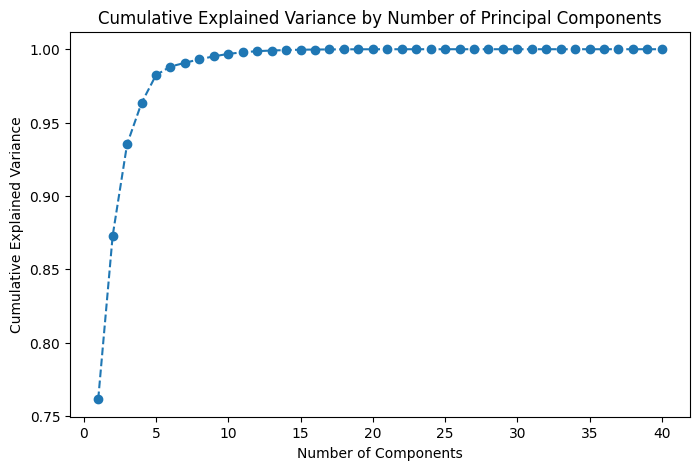

Number of components explaining 95% variance: 4


In [37]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()
n_components = np.argmax(pca.explained_variance_ratio_.cumsum() >= 0.95) + 1
print(f"Number of components explaining 95% variance: {n_components}")

In [38]:
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_rfe)
X_test_pca = pca.fit_transform(X_test_rfe)

In [39]:
log_reg = LogisticRegression()
log_reg.fit(X_train_pca, y_train)

LogisticRegression()

In [40]:
y_pred = log_reg.predict(X_test_pca)

In [41]:
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.63      0.76     20478
         1.0       0.08      0.57      0.14      1200

    accuracy                           0.62     21678
   macro avg       0.52      0.60      0.45     21678
weighted avg       0.91      0.62      0.72     21678

Confusion Matrix:
 [[12827  7651]
 [  519   681]]
Accuracy: 0.6231202140418858


## GridSearchCV

### Finding best parameters

In [43]:
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'max_iter': [100, 500, 1000] 
}

log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='f1', verbose=0)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Best Parameters: {'C': 100, 'max_iter': 100, 'penalty': 'l2'}
Best Score: 0.7069540548324215


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Using Best Parameters

In [44]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [45]:
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.60      0.74     20478
         1.0       0.10      0.75      0.17      1200

    accuracy                           0.61     21678
   macro avg       0.54      0.67      0.46     21678
weighted avg       0.93      0.61      0.71     21678

Confusion Matrix:
 [[12242  8236]
 [  300   900]]
Accuracy: 0.6062367377064305


## Adjusting Threshold

Best threshold for F1-score: 0.6008725682865143


/var/folders/nc/y24xw0zx141083cy3_vhwjw40000gn/T/ipykernel_34397/134292414.py:3: RuntimeWarning: invalid value encountered in divide
  f1_scores = np.where((precision + recall) == 0, 0, 2 * (precision * recall) / (precision + recall))


Text(0.5, 1.0, 'Precision-Recall Curve')

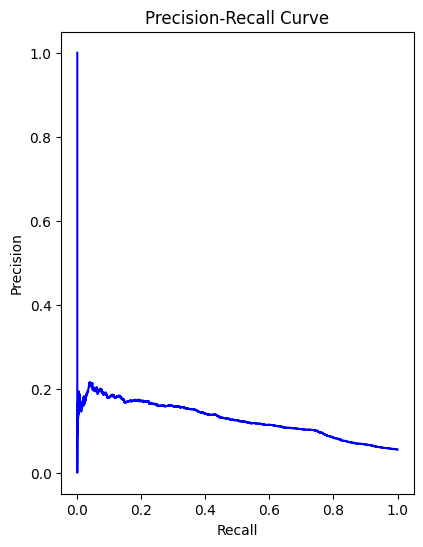

In [46]:
y_prob = best_model.predict_proba(X_test)[:, 1]
precision, recall, threshold = precision_recall_curve(y_test, y_prob)
f1_scores = np.where((precision + recall) == 0, 0, 2 * (precision * recall) / (precision + recall))
best_threshold = threshold[np.argmax(f1_scores)]
print(f"Best threshold for F1-score: {best_threshold}")

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

In [47]:
y_pred_best_threshold = (y_prob >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_best_threshold))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_threshold))
print("Accuracy:", accuracy_score(y_test, y_pred_best_threshold))

              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92     20478
         1.0       0.15      0.36      0.21      1200

    accuracy                           0.85     21678
   macro avg       0.56      0.62      0.57     21678
weighted avg       0.91      0.85      0.88     21678

Confusion Matrix:
 [[18031  2447]
 [  763   437]]
Accuracy: 0.8519236091890395


## K-Folds Cross Validation

In [48]:
folds = [fold_1, fold_2, fold_3, fold_4, fold_5]
smotes = [smote_fold_1, smote_fold_2, smote_fold_3, smote_fold_4, smote_fold_5]

for i in range(len(folds)):
    test_fold = folds[i]
    train_folds = [fold for j, fold in enumerate(smotes) if j != i]
    X_train = pd.concat([fold.drop(columns=columns_drop) for fold in train_folds], axis=0)
    y_train = pd.concat([fold['fraud_status'] for fold in train_folds], axis=0)
    X_test = test_fold.drop(columns=columns_drop)
    y_test = test_fold['fraud_status']

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    best_model.fit(X_train_scaled, y_train)
    y_pred = best_model.predict(X_test_scaled)
    y_pred_best_threshold = (y_pred >= best_threshold).astype(int)
    print(f"Classification Report for fold {i + 1}:\n", classification_report(y_test, y_pred_best_threshold))
    print(f"Confusion Matrix for fold {i + 1}:\n", confusion_matrix(y_test, y_pred_best_threshold))
    print(f"Accuracy for fold {i + 1}: {accuracy_score(y_test, y_pred_best_threshold):.4f}")
    print("-" * 50)


Classification Report for fold 1:
               precision    recall  f1-score   support

         0.0       0.98      0.77      0.86     20479
         1.0       0.15      0.70      0.25      1200

    accuracy                           0.77     21679
   macro avg       0.57      0.74      0.56     21679
weighted avg       0.93      0.77      0.83     21679

Confusion Matrix for fold 1:
 [[15859  4620]
 [  362   838]]
Accuracy for fold 1: 0.7702
--------------------------------------------------
Classification Report for fold 2:
               precision    recall  f1-score   support

         0.0       0.98      0.77      0.86     20479
         1.0       0.15      0.72      0.25      1200

    accuracy                           0.77     21679
   macro avg       0.57      0.74      0.56     21679
weighted avg       0.93      0.77      0.83     21679

Confusion Matrix for fold 2:
 [[15771  4708]
 [  341   859]]
Accuracy for fold 2: 0.7671
-----------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report for fold 3:
               precision    recall  f1-score   support

         0.0       0.98      0.77      0.86     20478
         1.0       0.16      0.74      0.26      1201

    accuracy                           0.76     21679
   macro avg       0.57      0.75      0.56     21679
weighted avg       0.93      0.76      0.83     21679

Confusion Matrix for fold 3:
 [[15669  4809]
 [  310   891]]
Accuracy for fold 3: 0.7639
--------------------------------------------------
Classification Report for fold 4:
               precision    recall  f1-score   support

         0.0       0.98      0.76      0.86     20478
         1.0       0.16      0.75      0.26      1201

    accuracy                           0.76     21679
   macro avg       0.57      0.75      0.56     21679
weighted avg       0.94      0.76      0.82     21679

Confusion Matrix for fold 4:
 [[15610  4868]
 [  306   895]]
Accuracy for fold 4: 0.7613
-----------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
